In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy import signal
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns

from tqdm import tqdm

import sys
sys.path.append('/Users/ag1880/Github_repos/Milstein-Lab/dentate_circuit_model/')
from optimize_dynamic_model import get_binary_input_patterns

%matplotlib inline

In [2]:
class dentate_network(nn.Module):
    def __init__(self, lr):
        self.lr = lr
        self.input_size = 7
        self.output_size = 128
        self.ffi_size = 7
        
        super().__init__()

        self.out_in  = nn.Linear(self.input_size, self.output_size)
        self.ffi_in  = nn.Linear(self.input_size, self.ffi_size,bias=False)
        self.out_ffi = nn.Linear(self.ffi_size, self.output_size,bias=False)

        # Initialize weights to positive values
        self.out_in.weight.data = self.out_in.weight.data.log_normal_(0, 0.8)
        self.ffi_in.weight.data = self.ffi_in.weight.data.uniform_(0, 1)
        self.out_ffi.weight.data = self.out_ffi.weight.data.uniform_(-0.1, 0)
        
        self.lossCriterion = nn.MSELoss()
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        
        
    def forward(self, input_pattern):
        out1 = self.out_in(input_pattern)
        
        out2 = self.ffi_in(input_pattern)
        out2 = self.out_ffi(out2)
        
        output = out1 + out2
        output = F.elu(output-1)+1
        return output
    
    def forward_relu(self, input_pattern):
        out1 = self.out_in(input_pattern)
        
        out2 = self.ffi_in(input_pattern)
        out2 = self.out_ffi(out2)
        
        output = out1 + out2
        output = F.relu(output)
        return output
    
    def forward_linear(self, input_pattern):
        out1 = self.out_in(input_pattern)
        out2 = self.ffi_in(input_pattern)
        out2 = self.out_ffi(out2)
        output = out1 + out2
        return output
    
    
    def train(self,epochs,all_patterns):
        losses = []
        for i in tqdm(range(epochs)):
            self.optimizer.zero_grad()
            
            pattern_index = np.random.randint(0,128)
            input_pattern = all_patterns[pattern_index]
            
            output = self.forward(input_pattern)
            target = torch.eye(128)[pattern_index]
            
            loss = self.lossCriterion(output,target)
    
            losses.append(loss.detach())
            loss.backward()
            self.optimizer.step()
            
            self.out_in.weight.data = self.out_in.weight.data.clamp(0,100)
            self.ffi_in.weight.data = self.ffi_in.weight.data.clamp(0,100)
            self.out_ffi.weight.data = self.out_ffi.weight.data.clamp(-100,0)
            
        return losses

In [3]:
# Create network
dentate_net = dentate_network(lr=0.001)
all_patterns = torch.tensor(get_binary_input_patterns(7)).type(torch.float32)

In [4]:
# Save initial state
w_init = {'out_in': dentate_net.out_in.weight.detach().numpy().flatten(),
          'ffi_in': dentate_net.ffi_in.weight.detach().numpy().flatten(),
          'out_ffi': dentate_net.out_ffi.weight.detach().numpy().flatten()}

# b_init = {'out_in': dentate_net.out_in.bias.detach().numpy().flatten(),
#           'ffi_in': dentate_net.ffi_in.bias.detach().numpy().flatten(),
#           'out_ffi': dentate_net.out_ffi.bias.detach().numpy().flatten()}

output_init = []
for pattern in all_patterns:
    output_init.append(list(dentate_net.forward(pattern).detach()))
output_init = np.array(output_init)

In [5]:
# Train network
epochs = 10**6
losses = dentate_net.train(epochs, all_patterns)

100%|██████████| 1000000/1000000 [05:52<00:00, 2839.28it/s]


In [6]:
# Save final state
w_final = {'out_in': dentate_net.out_in.weight.detach().numpy().flatten(),
          'ffi_in': dentate_net.ffi_in.weight.detach().numpy().flatten(),
          'out_ffi': dentate_net.out_ffi.weight.detach().numpy().flatten()}

# b_final = {'out_in': dentate_net.out_in.bias.detach().numpy().flatten(),
#           'ffi_in': dentate_net.ffi_in.bias.detach().numpy().flatten(),
#           'out_ffi': dentate_net.out_ffi.bias.detach().numpy().flatten()}

output_final = []
for pattern in all_patterns:
    output_final.append(list(dentate_net.forward(pattern).detach()))
output_final = np.array(output_final)

output_final_relu = []
for pattern in all_patterns:
    output_final_relu.append(list(dentate_net.forward_relu(pattern).detach()))
output_final_relu = np.array(output_final_relu)

output_final_linear = []
for pattern in all_patterns:
    output_final_linear.append(list(dentate_net.forward_linear(pattern).detach()))
output_final_linear = np.array(output_final_linear)

ffi_final = []
for pattern in all_patterns:
    ffi_final.append(list(dentate_net.ffi_in(pattern).detach()))
ffi_final = np.array(ffi_final)

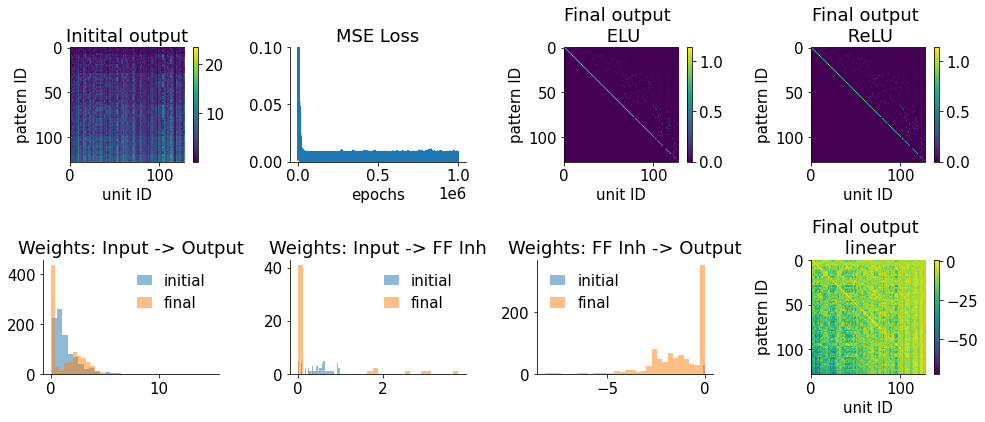

In [7]:
matplotlib.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(14,8.5))
axes = gs.GridSpec(nrows=3, ncols=12)
    
# Row 1: output activities
ax = fig.add_subplot(axes[0,0:3])
im = ax.imshow(output_init)
ax.set_title('Initital output')
ax.set_xlabel('unit ID')
ax.set_ylabel('pattern ID')
cbar = plt.colorbar(im, ax=ax)

ax = fig.add_subplot(axes[0,3:6])
ax.plot(losses)
ax.set_xlabel('epochs')
ax.set_title('MSE Loss')
ax.set_ylim([0,max(losses)])
ax.set_ylim([0,0.1])

ax = fig.add_subplot(axes[0,6:9])
im = ax.imshow(output_final)
ax.set_title('Final output \n ELU')
ax.set_xlabel('unit ID')
ax.set_ylabel('pattern ID')
cbar = plt.colorbar(im, ax=ax)

ax = fig.add_subplot(axes[0,9:12])
im = ax.imshow(output_final)
ax.set_title('Final output \n ReLU')
ax.set_xlabel('unit ID')
ax.set_ylabel('pattern ID')
cbar = plt.colorbar(im, ax=ax)

ax = fig.add_subplot(axes[1,9:12])
im = ax.imshow(output_final_linear)
ax.set_title('Final output \n linear')
ax.set_xlabel('unit ID')
ax.set_ylabel('pattern ID')
cbar = plt.colorbar(im, ax=ax)


# Row 2: weights
ax = fig.add_subplot(axes[1,0:3])
ax.hist(w_init['out_in'],30,alpha=0.5,label='initial')
ax.hist(w_final['out_in'],30,alpha=0.5,label='final')
ax.set_title('Weights: Input -> Output')
ax.legend(loc='best', frameon=False,handlelength=1)

ax = fig.add_subplot(axes[1,3:6])
ax.hist(w_init['ffi_in'],30,alpha=0.5,label='initial')
ax.hist(w_final['ffi_in'],30,alpha=0.5,label='final')
ax.set_title('Weights: Input -> FF Inh')
ax.legend(loc='best', frameon=False,handlelength=1)

ax = fig.add_subplot(axes[1,6:9])
ax.hist(w_init['out_ffi'],30,alpha=0.5,label='initial')
ax.hist(w_final['out_ffi'],30,alpha=0.5,label='final')
ax.set_title('Weights: FF Inh -> Output')
ax.legend(loc='best', frameon=False,handlelength=1)


# Row 3: biases
# ax = fig.add_subplot(axes[2,0:3])
# ax.hist(b_init['out_in'],30,alpha=0.5,label='initial')
# ax.hist(b_final['out_in'],30,alpha=0.5,label='final')
# ax.set_title('Biases: Input -> Output')
# ax.legend(loc='best', frameon=False,handlelength=1)

# ax = fig.add_subplot(axes[2,3:6])
# ax.hist(b_init['ffi_in'],7,alpha=0.5,label='initial')
# ax.hist(b_final['ffi_in'],7,alpha=0.5,label='final')
# ax.set_title('Biases: Input -> FF Inh')
# ax.legend(loc='best', frameon=False,handlelength=1)

# ax = fig.add_subplot(axes[2,6:9])
# ax.hist(b_init['out_ffi'],30,alpha=0.5,label='initial')
# ax.hist(b_final['out_ffi'],30,alpha=0.5,label='final')
# ax.set_title('Biases: FF Inh -> Output')
# ax.legend(loc='best', frameon=False,handlelength=1)


sns.despine()
fig.tight_layout()
plt.show()

# name = "backprop_network_FFI_MSE_ELU_nonnegative_lognormal"
# fig.savefig('../plots/'+name+'.png', edgecolor='white', dpi=300, facecolor='white', transparent=True)

In [8]:
np.max(output_final)

1.1364288

In [9]:
np.max(output_final_linear)

1.1364288

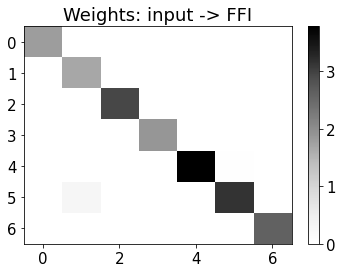

In [10]:
w = dentate_net.ffi_in.weight.data
m = np.argmax(w,axis=1)
idx = np.argsort(m)
w = w[idx]

plt.imshow(w,aspect='auto',cmap='Greys')
plt.colorbar()
plt.title('Weights: input -> FFI')
plt.show()

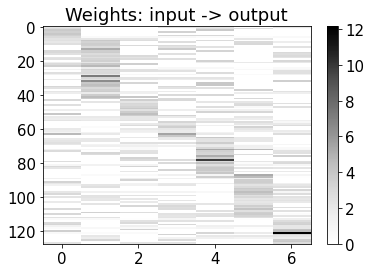

In [11]:
w = dentate_net.out_in.weight.data

m = np.argmax(w,axis=1)
idx = np.argsort(m)
w = w[idx]

plt.imshow(w,aspect='auto',interpolation='nearest',cmap='Greys')
plt.title('Weights: input -> output')
plt.colorbar()
plt.show()

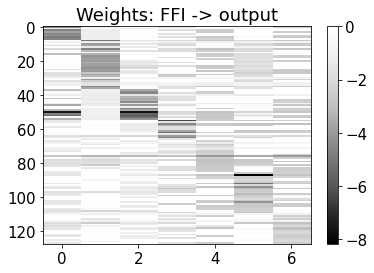

In [12]:
inh = dentate_net.out_ffi.weight.data

m = np.argmin(inh,axis=1)
idx = np.argsort(m)
inh = inh[idx]

plt.imshow(inh,aspect='auto',interpolation='nearest',cmap='Greys_r')
plt.title('Weights: FFI -> output')
plt.colorbar()
plt.show()

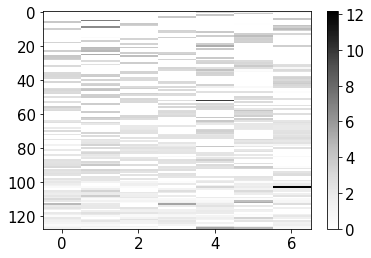

In [13]:
w = dentate_net.out_in.weight.data
plt.imshow(w,aspect='auto',interpolation='nearest',cmap='Greys')
plt.colorbar()
plt.show()

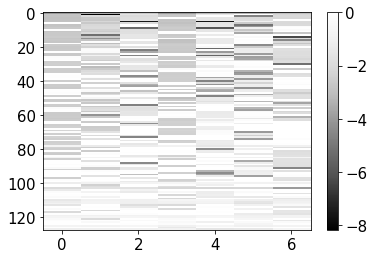

In [14]:
ffi_in = dentate_net.ffi_in.weight.data
m = np.argmax(ffi_in,axis=1)
ffi_idx = np.argsort(m)

inh = dentate_net.out_ffi.weight.data
sorted_interneurons = inh[:,ffi_idx]

plt.imshow(sorted_interneurons,aspect='auto',interpolation='nearest',cmap='Greys_r')
# plt.imshow(inh,aspect='auto',interpolation='nearest',cmap='Greys_r')
plt.colorbar()
plt.show()

tensor([1., 1., 0., 0., 0., 1., 0.])


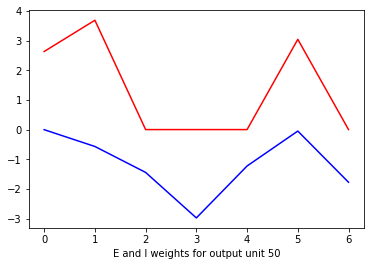

In [137]:
# sort interneurons by their preferred input
ffi_in = dentate_net.ffi_in.weight.data
m = np.argmax(ffi_in,axis=1)
ffi_idx = np.argsort(m)

inh = dentate_net.out_ffi.weight.data
sorted_interneurons = inh[:,ffi_idx]

exc_w = dentate_net.out_in.weight.data
centered_exc = np.zeros([128,7])
centered_inh = np.zeros([128,7])
for i in range(128):
    output_unit = exc_w[i]
    interneuron = sorted_interneurons[i]
    if i==50:
        plt.plot(output_unit,color='red')
        plt.plot(interneuron,color='blue') 
        plt.xlabel(f'E and I weights for output unit {i}')
        print(all_patterns[i])
        
    #center the peak of activation
    n = np.argmax(output_unit)
    output_unit = np.roll(output_unit,3-n)
    interneuron = np.roll(interneuron,3-n)
    
    #average across output units
    centered_exc[i] = output_unit
    centered_inh[i] = interneuron

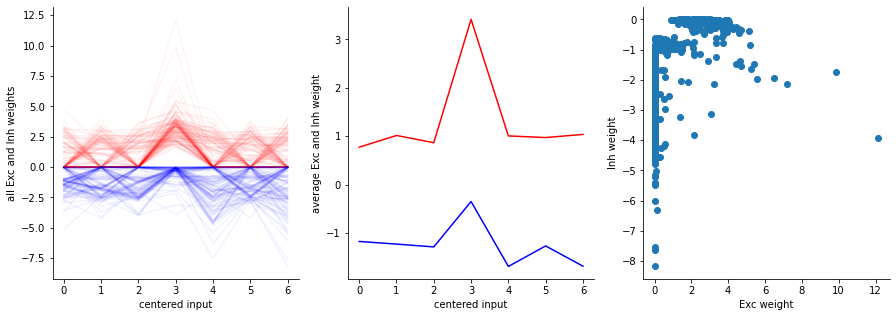

In [141]:
E = np.mean(centered_exc,axis=0)
I = np.mean(centered_inh,axis=0)

fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(centered_exc.T,color='red',alpha=0.05)
ax[0].plot(centered_inh.T,color='blue',alpha=0.05)
ax[0].set_xlabel('centered input')
ax[0].set_ylabel('all Exc and Inh weights')

ax[1].plot(E,color='red')
ax[1].plot(I,color='blue')
ax[1].set_xlabel('centered input')
ax[1].set_ylabel('average Exc and Inh weight')

ax[2].scatter(centered_exc,centered_inh)
ax[2].set_xlabel('Exc weight')
ax[2].set_ylabel('Inh weight')

sns.despine()
plt.show()

Preferred_pattern = 60


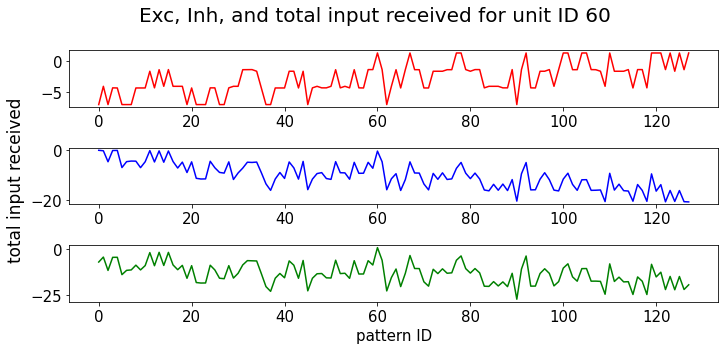

In [106]:
# out_in = dentate_net.out_in.weight.data
# out_ffi = dentate_net.out_ffi.weight.data
# ffi_in = dentate_net.ffi_in.weight.data

E = torch.zeros([128,128])
I = torch.zeros([128,128])
for i,pattern in enumerate(all_patterns):
    total_exc = dentate_net.out_in(pattern).detach()

    ffi_activity = dentate_net.ffi_in(pattern).detach()
    total_inh = dentate_net.out_ffi(ffi_activity).detach()
    
    E[i,:] = total_exc
    I[i,:] = total_inh

# for i in range(128):
#     exc = torch.abs(E[:,i])
#     norm_exc = (exc - torch.mean(exc)) / torch.max(exc)
#     E[:,i] = norm_exc

#     inh = torch.abs(I[:,i])
#     norm_inh = (inh - torch.mean(inh)) / torch.max(inh)
#     I[:,i] = norm_inh
    
T = E + I

unit_id = 60
print('Preferred_pattern =',unit_id)
fig,ax = plt.subplots(3,1,figsize=(10,5))
ax[0].plot(E[:,unit_id],color='red')
ax[1].plot(I[:,unit_id],color='blue')
ax[2].plot(T[:,unit_id],color='green')

ax[2].set_xlabel('pattern ID')
fig.text(-0.01, 0.5, 'total input received', va='center', rotation='vertical',fontsize=17)
plt.suptitle(f'Exc, Inh, and total input received for unit ID {unit_id}',fontsize=20)

fig.tight_layout()
plt.show()

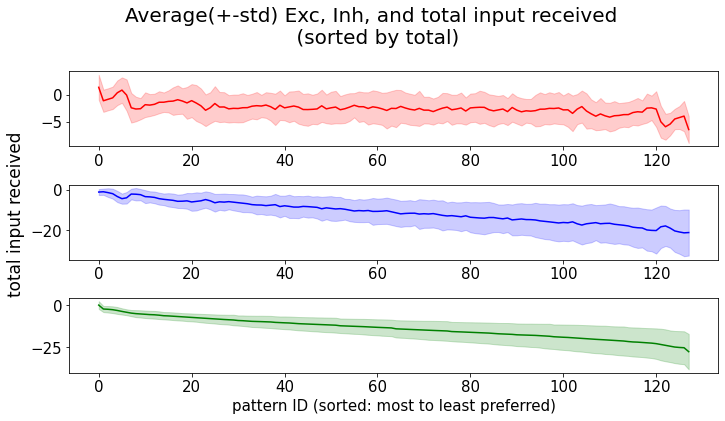

In [112]:
sorted_T,idx = torch.sort(T,axis=0,descending=True)

sorted_E = torch.empty_like(E)
sorted_I = torch.empty_like(I)
for unit in range(128):
    sorted_idx = idx[:,unit]
    sorted_E[:,unit] = E[sorted_idx,unit]
    sorted_I[:,unit] = I[sorted_idx,unit]

mean_E = torch.mean(sorted_E,axis=1)
mean_I = torch.mean(sorted_I,axis=1)
mean_T = torch.mean(sorted_T,axis=1)

std_E = torch.std(sorted_E,axis=1)
std_I = torch.std(sorted_I,axis=1)
std_T = torch.std(sorted_T,axis=1)

fig,ax = plt.subplots(3,1,figsize=(10,6))
ax[0].plot(mean_E,color='red')
ax[0].fill_between(x=range(128), y1=(mean_E-std_E), y2=(mean_E+std_E), color='red', alpha=0.2)
ax[1].plot(mean_I,color='blue')
ax[1].fill_between(x=range(128), y1=(mean_I-std_I), y2=(mean_I+std_I), color='blue', alpha=0.2)
ax[2].plot(mean_T,color='green')
ax[2].fill_between(x=range(128), y1=(mean_T-std_T), y2=(mean_T+std_T), color='green', alpha=0.2)

ax[2].set_xlabel('pattern ID (sorted: most to least preferred)')
fig.text(-0.01, 0.5, 'total input received', va='center', rotation='vertical',fontsize=17)
plt.suptitle(f'Average(+-std) Exc, Inh, and total input received \n (sorted by total)',fontsize=20)

fig.tight_layout()
plt.show()

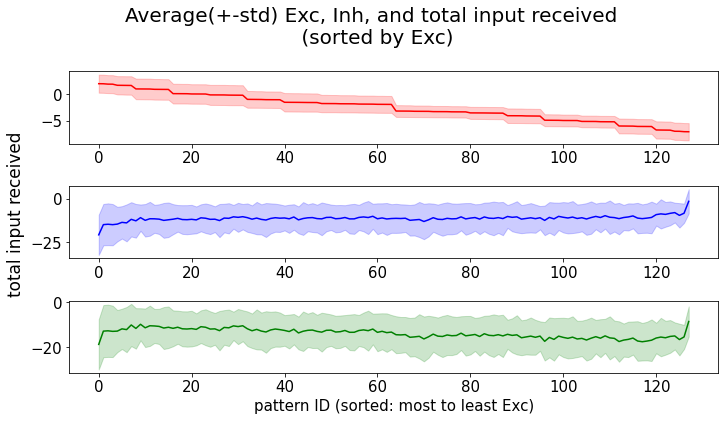

In [115]:
sorted_E,idx = torch.sort(E,axis=0,descending=True)

sorted_T = torch.empty_like(T)
sorted_I = torch.empty_like(I)
for unit in range(128):
    sorted_idx = idx[:,unit]
    sorted_T[:,unit] = T[sorted_idx,unit]
    sorted_I[:,unit] = I[sorted_idx,unit]

mean_E = torch.mean(sorted_E,axis=1)
mean_I = torch.mean(sorted_I,axis=1)
mean_T = torch.mean(sorted_T,axis=1)

std_E = torch.std(sorted_E,axis=1)
std_I = torch.std(sorted_I,axis=1)
std_T = torch.std(sorted_T,axis=1)

fig,ax = plt.subplots(3,1,figsize=(10,6))
ax[0].plot(mean_E,color='red')
ax[0].fill_between(x=range(128), y1=(mean_E-std_E), y2=(mean_E+std_E), color='red', alpha=0.2)
ax[1].plot(mean_I,color='blue')
ax[1].fill_between(x=range(128), y1=(mean_I-std_I), y2=(mean_I+std_I), color='blue', alpha=0.2)
ax[2].plot(mean_T,color='green')
ax[2].fill_between(x=range(128), y1=(mean_T-std_T), y2=(mean_T+std_T), color='green', alpha=0.2)

ax[2].set_xlabel('pattern ID (sorted: most to least Exc)')
fig.text(-0.01, 0.5, 'total input received', va='center', rotation='vertical',fontsize=17)
plt.suptitle(f'Average(+-std) Exc, Inh, and total input received \n (sorted by Exc)',fontsize=20)

fig.tight_layout()
plt.show()

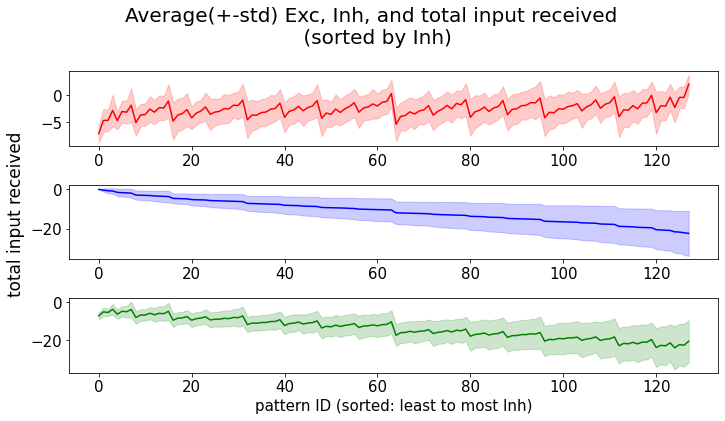

In [117]:
sorted_I,idx = torch.sort(I,axis=0,descending=True)

sorted_T = torch.empty_like(T)
sorted_E = torch.empty_like(E)
for unit in range(128):
    sorted_idx = idx[:,unit]
    sorted_T[:,unit] = T[sorted_idx,unit]
    sorted_E[:,unit] = E[sorted_idx,unit]

mean_E = torch.mean(sorted_E,axis=1)
mean_I = torch.mean(sorted_I,axis=1)
mean_T = torch.mean(sorted_T,axis=1)

std_E = torch.std(sorted_E,axis=1)
std_I = torch.std(sorted_I,axis=1)
std_T = torch.std(sorted_T,axis=1)

fig,ax = plt.subplots(3,1,figsize=(10,6))
ax[0].plot(mean_E,color='red')
ax[0].fill_between(x=range(128), y1=(mean_E-std_E), y2=(mean_E+std_E), color='red', alpha=0.2)
ax[1].plot(mean_I,color='blue')
ax[1].fill_between(x=range(128), y1=(mean_I-std_I), y2=(mean_I+std_I), color='blue', alpha=0.2)
ax[2].plot(mean_T,color='green')
ax[2].fill_between(x=range(128), y1=(mean_T-std_T), y2=(mean_T+std_T), color='green', alpha=0.2)

ax[2].set_xlabel('pattern ID (sorted: least to most Inh)')
fig.text(-0.01, 0.5, 'total input received', va='center', rotation='vertical',fontsize=17)
plt.suptitle(f'Average(+-std) Exc, Inh, and total input received \n (sorted by Inh)',fontsize=20)

fig.tight_layout()
plt.show()